In [ ]:
import pandas as pd
import re
import nltk
import torch
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertTokenizer, DistilBertModel
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords

nltk.download('stopwords')
from nltk.corpus import stopwords

df = pd.read_csv('/content/liarplus.csv')

# Preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        stop_words = set(stopwords.words('english'))
        text = ' '.join([word for word in text.split() if word not in stop_words])
        return text
    return str(text)

df = df.drop(['ID', 'File', 'Position', 'Context', 'Analysis'], axis=1)
df = df.dropna()

# Apply preprocessing
df['Statement'] = df['Statement'].apply(preprocess_text)
df['Topic'] = df['Topic'].str.replace(',', ' ', regex=False).str.replace('-', ' ', regex=False).apply(preprocess_text)
df['Location'] = df['Location'].apply(preprocess_text)
df['Speaker'] = df['Speaker'].str.replace('-', ' ', regex=False)
df['Label'] = df['Label'].str.replace('-', ' ', regex=False)

# Label encoding
label_encoder = LabelEncoder()
df['Party'] = label_encoder.fit_transform(df['Party'])
df['Label'] = label_encoder.fit_transform(df['Label'])
df['Location'] = label_encoder.fit_transform(df['Location'])
df['Speaker'] = label_encoder.fit_transform(df['Speaker'])
df['Topic'] = label_encoder.fit_transform(df['Topic'])

# Step 1: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=300)  # Adjust max_features as needed
tfidf_features = tfidf_vectorizer.fit_transform(df['Statement']).toarray()

# Step 2: BERT Embeddings
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

def get_bert_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**tokens)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Average pooling
    return embeddings[0].numpy()

bert_embeddings = np.array([get_bert_embedding(text) for text in df['Statement']])

# Step 3 (Optional): Word Embeddings using Word2Vec
sentences = [text.split() for text in df['Statement']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_features = np.array([
    np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv] or [np.zeros(100)], axis=0)
    for sentence in sentences
])

combined_features = np.hstack([tfidf_features, bert_embeddings, word2vec_features])

print("Combined feature shape:", combined_features.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Combined feature shape: (10040, 1168)


In [ ]:
X = combined_features
y = df['Label'].values

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_tensor = torch.tensor(X, dtype=torch.float32)

# GAN parameters
latent_dim = 100  # Size of random noise vector
data_dim = X.shape[1]
batch_size = 64
num_epochs = 100
learning_rate = 0.0002

# Define the Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, data_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, data_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, data_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initializing both of them
generator = Generator(latent_dim, data_dim)
discriminator = Discriminator(data_dim)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Training the GAN
for epoch in range(num_epochs):
    d_loss_epoch = 0
    g_loss_epoch = 0
    num_batches = 0

    for i in range(0, len(X_tensor), batch_size):

        real_data = X_tensor[i:i+batch_size]
        real_labels = torch.ones((real_data.size(0), 1))

        # Generate fake data
        z = torch.randn(real_data.size(0), latent_dim)
        fake_data = generator(z)
        fake_labels = torch.zeros((fake_data.size(0), 1))

        # Train the discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_data), real_labels)
        fake_loss = criterion(discriminator(fake_data.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train the generator
        optimizer_G.zero_grad()
        gen_labels = torch.ones((fake_data.size(0), 1))  # Trick discriminator to think fake is real
        g_loss = criterion(discriminator(fake_data), gen_labels)
        g_loss.backward()
        optimizer_G.step()


        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()
        num_batches += 1


    d_loss_epoch /= num_batches
    g_loss_epoch /= num_batches

    print(f"Epoch {epoch + 1}/{num_epochs} - D Loss: {d_loss_epoch:.4f} - G Loss: {g_loss_epoch:.4f}")

print("GAN training completed.")


# Generate new synthetic data
z = torch.randn(batch_size, latent_dim)
synthetic_data = generator(z).detach().numpy()
print("Generated synthetic data shape:", synthetic_data.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Epoch 1/100 - D Loss: 0.5399 - G Loss: 2.0387
Epoch 2/100 - D Loss: 0.0738 - G Loss: 4.7216
Epoch 3/100 - D Loss: 0.0272 - G Loss: 7.1629
Epoch 4/100 - D Loss: 0.0081 - G Loss: 8.1199
Epoch 5/100 - D Loss: 0.0065 - G Loss: 7.7857
Epoch 6/100 - D Loss: 0.0101 - G Loss: 5.9129
Epoch 7/100 - D Loss: 0.0156 - G Loss: 4.8092
Epoch 8/100 - D Loss: 0.0057 - G Loss: 5.4727
Epoch 9/100 - D Loss: 0.0033 - G Loss: 7.3687
Epoch 10/100 - D Loss: 0.0049 - G Loss: 10.2127
Epoch 11/100 - D Loss: 0.0038 - G Loss: 9.2177
Epoch 12/100 - D Loss: 0.0029 - G Loss: 8.6065
Epoch 13/100 - D Loss: 0.0039 - G Loss: 9.0995
Epoch 14/100 - D Loss: 0.0058 - G Loss: 8.9610
Epoch 15/100 - D Loss: 0.0064 - G Loss: 9.0196
Epoch 16/100 - D Loss: 0.0029 - G Loss: 8.2957
Epoch 17/100 - D Loss: 0.0076 - G Loss: 9.1324
Epoch 18/100 - D Loss: 0.0054 - G Loss: 9.2981
Epoch 19/100 - D Loss: 0.0052 - G Loss: 9.7620
Epoch 20/100 - D Loss: 0.0039 - G Loss: 8.9713
Epoch 21/100 - D Loss: 0.0029 - G Loss: 9.6030
Epoch 22/100 - D Loss

In [ ]:
#BiLSTM code

import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Define a fitness function to evaluate hyperparameters
def fitness_function(params, X_train, y_train, X_val, y_val, input_dim, output_dim, num_layers):
    hidden_dim, learning_rate = params

    # Define the BiLSTM model
    model = BiLSTM(input_dim, hidden_dim, output_dim, num_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)


    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


    num_epochs = 5
    model.train()
    for epoch in range(num_epochs):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()


    model.eval()
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    correct, total = 0, 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    return correct / total

# Genetic Algorithm for Hyperparameter Tuning
def genetic_algorithm(X_train, y_train, X_val, y_val, input_dim, output_dim, num_layers, num_generations=10, population_size=10):
    population = [(random.randint(64, 256), random.uniform(0.0001, 0.01)) for _ in range(population_size)]

    for generation in range(num_generations):
        fitness_scores = [fitness_function(individual, X_train, y_train, X_val, y_val, input_dim, output_dim, num_layers) for individual in population]

        sorted_population = [x for _, x in sorted(zip(fitness_scores, population), reverse=True)]
        population = sorted_population[:population_size // 2]

        offspring = []
        while len(offspring) < population_size - len(population):
            parent1, parent2 = random.sample(population, 2)
            child = (
                int((parent1[0] + parent2[0]) / 2),
                (parent1[1] + parent2[1]) / 2
            )
            offspring.append(child)

        for i in range(len(offspring)):
            if random.random() < 0.1:
                offspring[i] = (
                    random.randint(64, 256),
                    offspring[i][1] * random.uniform(0.8, 1.2)
                )

        population += offspring
        print(f"Generation {generation+1}/{num_generations}, Best Fitness: {max(fitness_scores):.4f}")

    best_index = fitness_scores.index(max(fitness_scores))
    return population[best_index]


X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


input_dim = X_train_split.shape[1]
output_dim = len(set(y_train))
num_layers = 2

# Run Genetic Algorithm
best_params = genetic_algorithm(X_train_split, y_train_split, X_val_split, y_val_split, input_dim, output_dim, num_layers)
print("Best Hyperparameters (hidden_dim, learning_rate):", best_params)

# Final training using the best hyperparameters
hidden_dim, learning_rate = best_params
final_model = BiLSTM(input_dim, hidden_dim, output_dim, num_layers)
final_criterion = nn.CrossEntropyLoss()
final_optimizer = optim.Adam(final_model.parameters(), lr=learning_rate)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
final_dataset = TensorDataset(X_train_tensor, y_train_tensor)
final_loader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True)

# Training the final model
num_epochs = 25
final_model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_x, batch_y in final_loader:
        final_optimizer.zero_grad()
        outputs = final_model(batch_x)
        loss = final_criterion(outputs, batch_y)
        loss.backward()
        final_optimizer.step()
        train_loss += loss.item()

    train_loss /= len(final_loader)
    print(f'Final Training Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}')

final_model.eval()
correct = 0
total = 0
with torch.no_grad():
    X_val_tensor = torch.tensor(X_val_split, dtype=torch.float32).unsqueeze(1)
    y_val_tensor = torch.tensor(y_val_split, dtype=torch.long)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for batch_x, batch_y in val_loader:
        outputs = final_model(batch_x)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on validation set: {accuracy:.2f}%')

Generation 1/10, Best Fitness: 0.2713
Generation 2/10, Best Fitness: 0.2520
Generation 3/10, Best Fitness: 0.2645
Generation 4/10, Best Fitness: 0.2670
Generation 5/10, Best Fitness: 0.2582
Generation 6/10, Best Fitness: 0.2626
Generation 7/10, Best Fitness: 0.2638
Generation 8/10, Best Fitness: 0.2670
Generation 9/10, Best Fitness: 0.2694
Generation 10/10, Best Fitness: 0.2582
Best Hyperparameters (hidden_dim, learning_rate): (158, 0.0011040841197521756)
Final Training Epoch 1/25, Loss: 1.7213
Final Training Epoch 2/25, Loss: 1.6877
Final Training Epoch 3/25, Loss: 1.6664
Final Training Epoch 4/25, Loss: 1.6387
Final Training Epoch 5/25, Loss: 1.5980
Final Training Epoch 6/25, Loss: 1.5453
Final Training Epoch 7/25, Loss: 1.4836
Final Training Epoch 8/25, Loss: 1.3870
Final Training Epoch 9/25, Loss: 1.2739
Final Training Epoch 10/25, Loss: 1.1368
Final Training Epoch 11/25, Loss: 0.9984
Final Training Epoch 12/25, Loss: 0.8328
Final Training Epoch 13/25, Loss: 0.6713
Final Training E

Loading and preparing the dataset...


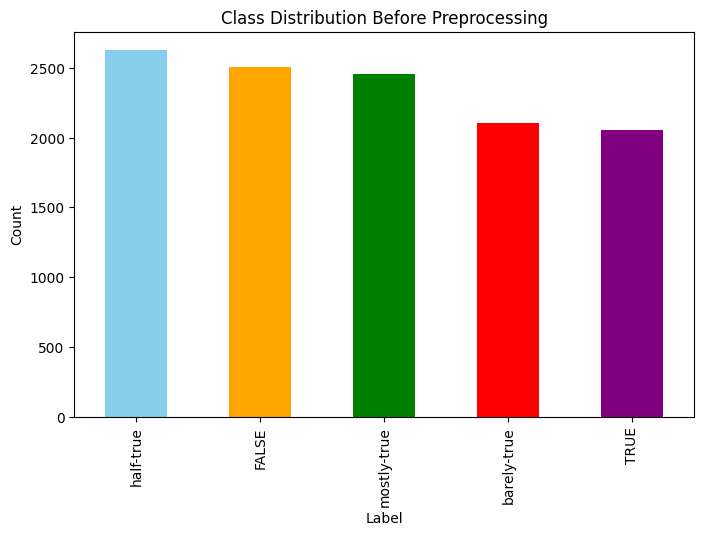

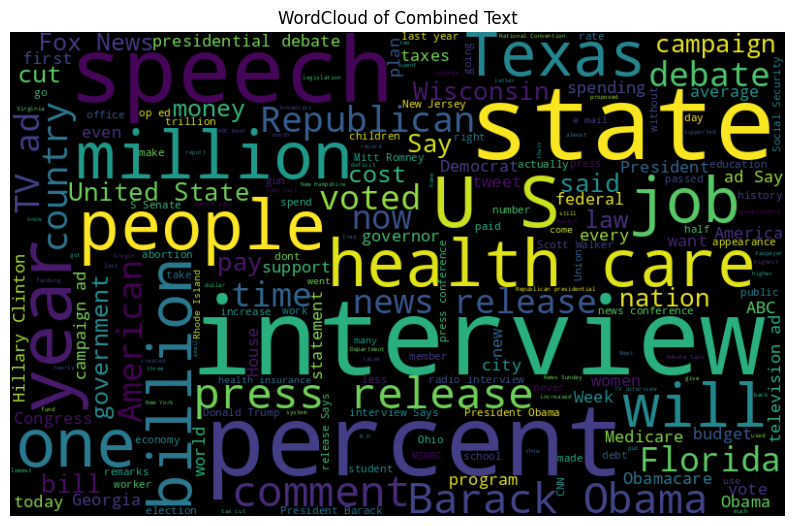

Early stopping triggered


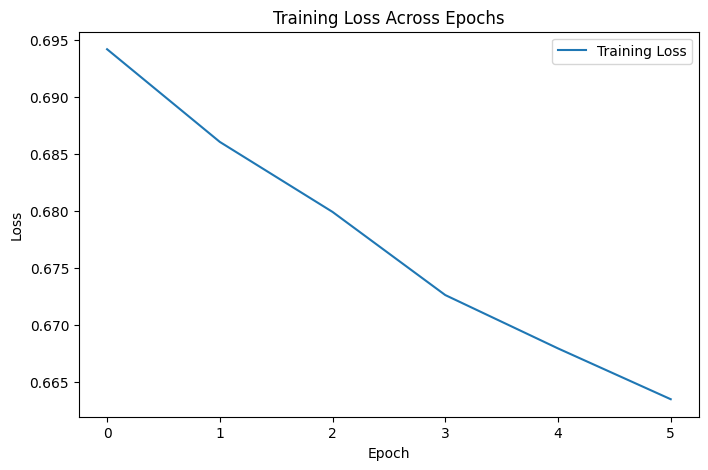

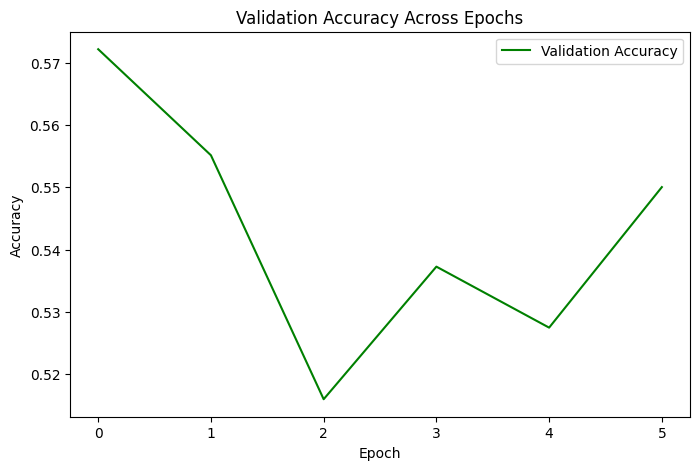


Testing all statements in the dataset...


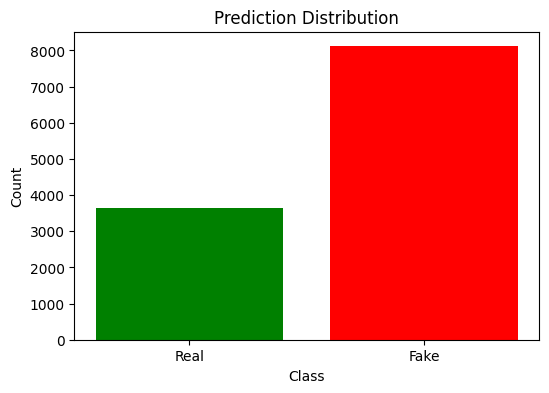

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from torch.utils.data import TensorDataset, DataLoader

# Define BiLSTM model
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(BiLSTM, self).__init__()
        self.embedding_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                           bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)

        lstm_out, _ = self.lstm(x)
        dropped = self.dropout(lstm_out[:, -1, :])
        out = self.fc(dropped)
        return out

# Preprocessing and visualization functions
def visualize_data(data):
    # Class distribution before preprocessing
    plt.figure(figsize=(8, 5))
    data['Label'].value_counts().plot(kind='bar', color=['skyblue', 'orange', 'green', 'red', 'purple', 'brown'])
    plt.title('Class Distribution Before Preprocessing')
    plt.ylabel('Count')
    plt.xlabel('Label')
    plt.show()

    # WordCloud of text data
    combined_text = ' '.join(data['Statement'].fillna('') + ' ' + data['Context'].fillna(''))
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(combined_text)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title('WordCloud of Combined Text')
    plt.show()

def plot_training_metrics(train_losses, val_accuracies):
    # Loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss Across Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Validation accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.title('Validation Accuracy Across Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
def preprocess_text(text, tokenizer, max_len=400):
    sequences = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return torch.FloatTensor(padded)


# Main training function
def train_model(data):
    label_mapping = {
        'TRUE': 1,
        'mostly-true': 1,
        'half-true': 0,
        'barely-true': 0,
        'FALSE': 0,
        'pants-on-fire': 0
    }

    data['binary_label'] = data['Label'].map(label_mapping)
    data.dropna(subset=['binary_label'], inplace=True)
    data['combined_text'] = (
        data['Statement'].fillna('') + ' ' +
        data['Context'].fillna('') + ' ' +
        data['Analysis'].fillna('')
    )

    visualize_data(data)  # Visualize the data

    max_words = 30000
    max_len = 400
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(data['combined_text'])

    sequences = tokenizer.texts_to_sequences(data['combined_text'])
    X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    y = data['binary_label'].values

    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)

    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y)

    input_dim = X_train.shape[1]
    hidden_dim = 512
    output_dim = 2
    num_layers = 3
    batch_size = 64

    model = BiLSTM(input_dim, hidden_dim, output_dim, num_layers)
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, 1.5]))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-6)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    num_epochs = 25
    best_accuracy = 0
    patience = 5
    patience_counter = 0
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        epoch_accuracy = correct / total
        train_losses.append(total_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            test_dataset = TensorDataset(X_test, y_test)
            test_loader = DataLoader(test_dataset, batch_size=batch_size)
            correct = 0
            total = 0

            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

            accuracy = correct / total
            val_accuracies.append(accuracy)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    plot_training_metrics(train_losses, val_accuracies)
    return model, tokenizer

# Test the statements and visualize results
def test_statements(model, tokenizer, statements_df):
    model.eval()
    results = []
    real_count = 0
    fake_count = 0

    for idx, row in statements_df.iterrows():
        combined_text = (
            str(row['Statement']) + ' ' +
            str(row['Context']) + ' ' +
            str(row['Analysis'])
        )
        input_tensor = preprocess_text(combined_text, tokenizer)

        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.softmax(output, dim=1)
            prediction = torch.argmax(probabilities, dim=1).item()

            if prediction == 1:
                real_count += 1
            else:
                fake_count += 1

    # Prediction distribution
    plt.figure(figsize=(6, 4))
    plt.bar(['Real', 'Fake'], [real_count, fake_count], color=['green', 'red'])
    plt.title('Prediction Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

# Main function to execute the training and visualization pipeline
def main():
    print("Loading and preparing the dataset...")
    data = pd.read_csv('/content/liarplus.csv')


    model, tokenizer = train_model(data)
    print("\nTesting all statements in the dataset...")
    test_statements(model, tokenizer, data)

if __name__ == "__main__":
    main()


Loading and preparing the dataset...


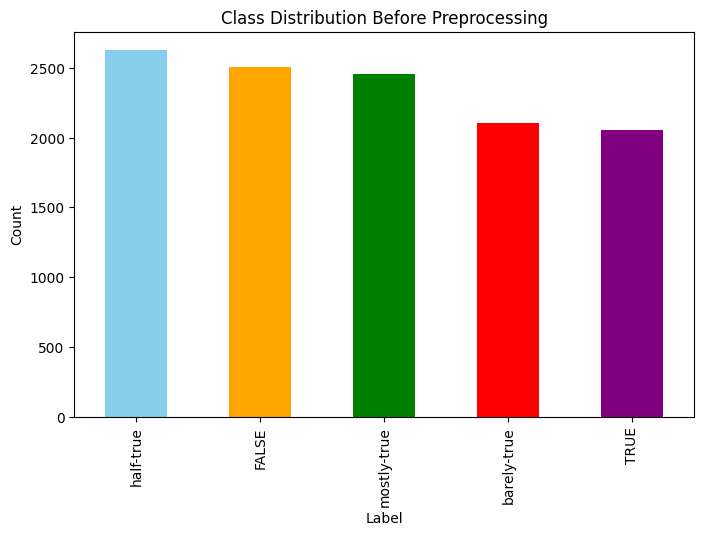

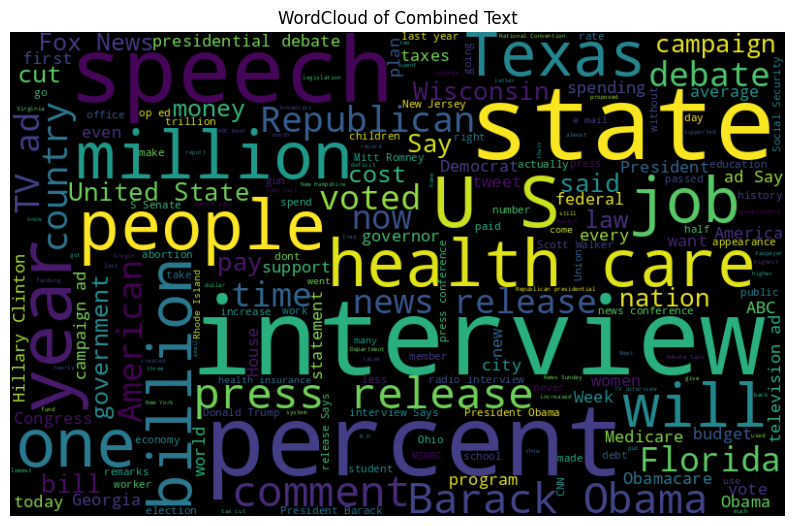

Early stopping triggered


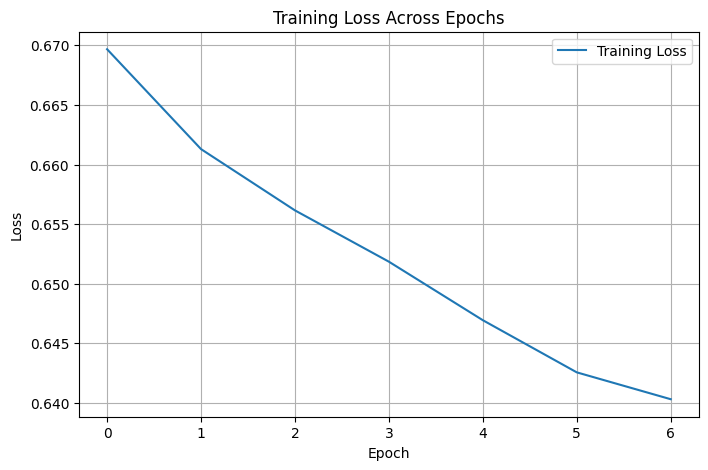

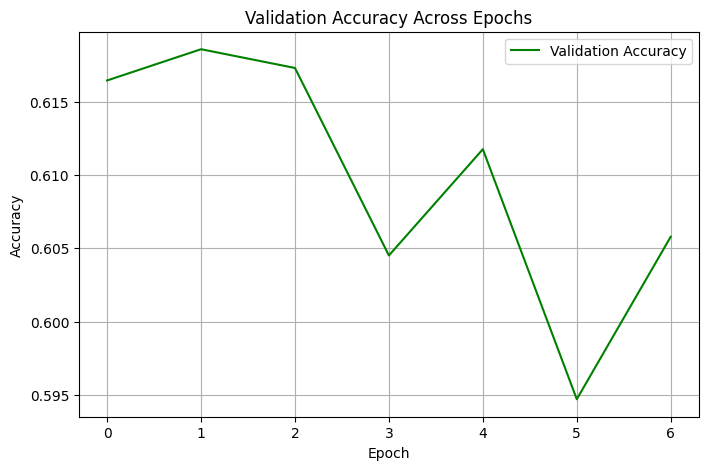

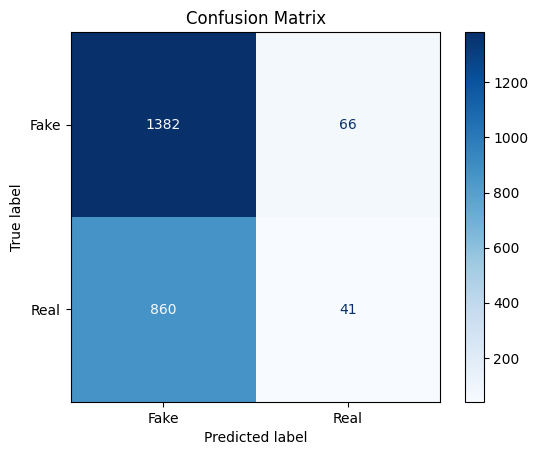


Testing all statements in the dataset...


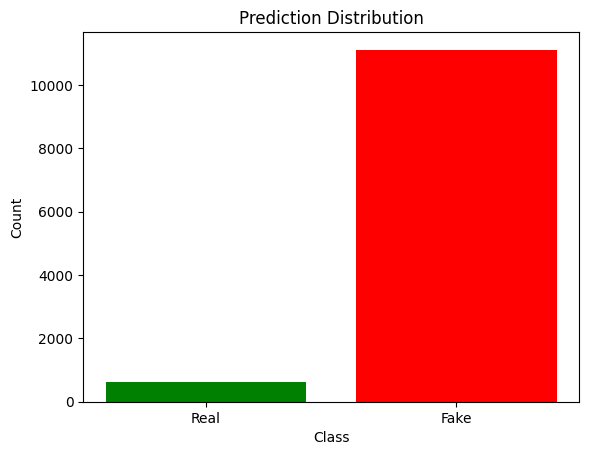

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns

# Define BiLSTM model
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)

        lstm_out, _ = self.lstm(x)
        dropped = self.dropout(lstm_out[:, -1, :])
        out = self.fc(dropped)
        return out

# Data visualization functions
def visualize_data(data):
    # Class distribution before preprocessing
    plt.figure(figsize=(8, 5))
    data['Label'].value_counts().plot(kind='bar', color=['skyblue', 'orange', 'green', 'red', 'purple', 'brown'])
    plt.title('Class Distribution Before Preprocessing')
    plt.ylabel('Count')
    plt.xlabel('Label')
    plt.show()

    # WordCloud of text data
    combined_text = ' '.join(data['Statement'].fillna('') + ' ' + data['Context'].fillna(''))
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(combined_text)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title('WordCloud of Combined Text')
    plt.show()

def plot_training_metrics(train_losses, val_accuracies):
    # Loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss Across Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Validation accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.title('Validation Accuracy Across Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Preprocess text into padded sequences
def preprocess_text(text, tokenizer, max_len=400):
    sequences = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return torch.FloatTensor(padded)

# Train the BiLSTM model
def train_model(data):
    label_mapping = {
        'TRUE': 1,
        'mostly-true': 1,
        'half-true': 0,
        'barely-true': 0,
        'FALSE': 0,
        'pants-on-fire': 0
    }

    data['binary_label'] = data['Label'].map(label_mapping)
    data.dropna(subset=['binary_label'], inplace=True)
    data['combined_text'] = (
        data['Statement'].fillna('') + ' ' +
        data['Context'].fillna('') + ' ' +
        data['Analysis'].fillna('')
    )

    visualize_data(data)

    max_words = 30000
    max_len = 400
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(data['combined_text'])

    sequences = tokenizer.texts_to_sequences(data['combined_text'])
    X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    y = data['binary_label'].values

    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)

    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y)

    input_dim = X_train.shape[1]
    hidden_dim = 512
    output_dim = 2
    num_layers = 3
    batch_size = 64

    model = BiLSTM(input_dim, hidden_dim, output_dim, num_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-6)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    num_epochs = 25
    patience = 5
    patience_counter = 0
    train_losses = []
    val_accuracies = []

    best_accuracy = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            outputs = model(X_test)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y_test).sum().item() / y_test.size(0)
            val_accuracies.append(accuracy)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    plot_training_metrics(train_losses, val_accuracies)

    # Confusion matrix
    cm = confusion_matrix(y_test.numpy(), predicted.numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    return model, tokenizer

# Test statements
def test_statements(model, tokenizer, data):
    model.eval()
    real_count = 0
    fake_count = 0
    y_pred = []
    y_true = []

    for _, row in data.iterrows():
        text = row['combined_text']
        label = row['binary_label']
        input_tensor = preprocess_text(text, tokenizer)
        with torch.no_grad():
            output = model(input_tensor)
            prediction = torch.argmax(output, dim=1).item()
            y_pred.append(prediction)
            y_true.append(label)
            if prediction == 1:
                real_count += 1
            else:
                fake_count += 1

    # Prediction distribution
    plt.bar(['Real', 'Fake'], [real_count, fake_count], color=['green', 'red'])
    plt.title("Prediction Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

# Main function
def main():
    print("Loading and preparing the dataset...")
    data = pd.read_csv('/content/liarplus.csv')

    model, tokenizer = train_model(data)
    print("\nTesting all statements in the dataset...")
    test_statements(model, tokenizer, data)

if __name__ == "__main__":
    main()
